In [1]:
"""
Домашнее задание 4
Переобучение 1
Добиться от классифкатора fashionminst переобучения 
за счет изменения архитектуры и гиперпараметров.
Критерии оценки: По графикам ошибок и точности для 
тренировочного и тестового множества должно 
быть понятно, что переобучение наступило
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist
import numpy as np

from pprint import pprint 

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [3]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [5]:
models = {'default': Net(True, False)} #, 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [7]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, train_loader, train_log)
    test(models, test_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.265755
Train Epoch: 1 [10000/50000 (20%)]	Losses default: 0.632516
Train Epoch: 1 [20000/50000 (40%)]	Losses default: 0.683979
Train Epoch: 1 [30000/50000 (60%)]	Losses default: 0.604496
Train Epoch: 1 [40000/50000 (80%)]	Losses default: 0.535571
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 0.449007
Test set:
default: Loss: 0.4294	Accuracy: 42553.0/50000 (85%)

Test set:
default: Loss: 0.4683	Accuracy: 8349.0/10000 (83%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.541571
Train Epoch: 2 [10000/50000 (20%)]	Losses default: 0.323622
Train Epoch: 2 [20000/50000 (40%)]	Losses default: 0.316757
Train Epoch: 2 [30000/50000 (60%)]	Losses default: 0.304035
Train Epoch: 2 [40000/50000 (80%)]	Losses default: 0.458577
Train Epoch: 2 [50000/50000 (100%)]	Losses default: 0.439815
Test set:
default: Loss: 0.3606	Accuracy: 43569.0/50000 (87%)

Test set:
default: Loss: 0.4109	Accuracy: 8517.0/10000 (85%)

Train Epoch: 3 [0/50000 (0%)]	Losses d

Train Epoch: 18 [10000/50000 (20%)]	Losses default: 0.229578
Train Epoch: 18 [20000/50000 (40%)]	Losses default: 0.094369
Train Epoch: 18 [30000/50000 (60%)]	Losses default: 0.287151
Train Epoch: 18 [40000/50000 (80%)]	Losses default: 0.193768
Train Epoch: 18 [50000/50000 (100%)]	Losses default: 0.225519
Test set:
default: Loss: 0.1777	Accuracy: 46846.0/50000 (94%)

Test set:
default: Loss: 0.3345	Accuracy: 8838.0/10000 (88%)

Train Epoch: 19 [0/50000 (0%)]	Losses default: 0.192334
Train Epoch: 19 [10000/50000 (20%)]	Losses default: 0.158338
Train Epoch: 19 [20000/50000 (40%)]	Losses default: 0.243263
Train Epoch: 19 [30000/50000 (60%)]	Losses default: 0.245246
Train Epoch: 19 [40000/50000 (80%)]	Losses default: 0.207999
Train Epoch: 19 [50000/50000 (100%)]	Losses default: 0.197115
Test set:
default: Loss: 0.1672	Accuracy: 47073.0/50000 (94%)

Test set:
default: Loss: 0.3262	Accuracy: 8852.0/10000 (89%)

Train Epoch: 20 [0/50000 (0%)]	Losses default: 0.194593
Train Epoch: 20 [10000/500

Train Epoch: 35 [10000/50000 (20%)]	Losses default: 0.254744
Train Epoch: 35 [20000/50000 (40%)]	Losses default: 0.068431
Train Epoch: 35 [30000/50000 (60%)]	Losses default: 0.141713
Train Epoch: 35 [40000/50000 (80%)]	Losses default: 0.163739
Train Epoch: 35 [50000/50000 (100%)]	Losses default: 0.077188
Test set:
default: Loss: 0.1038	Accuracy: 48182.0/50000 (96%)

Test set:
default: Loss: 0.3550	Accuracy: 8849.0/10000 (88%)

Train Epoch: 36 [0/50000 (0%)]	Losses default: 0.104363
Train Epoch: 36 [10000/50000 (20%)]	Losses default: 0.096280
Train Epoch: 36 [20000/50000 (40%)]	Losses default: 0.036175
Train Epoch: 36 [30000/50000 (60%)]	Losses default: 0.148645
Train Epoch: 36 [40000/50000 (80%)]	Losses default: 0.088787
Train Epoch: 36 [50000/50000 (100%)]	Losses default: 0.164260
Test set:
default: Loss: 0.0950	Accuracy: 48408.0/50000 (97%)

Test set:
default: Loss: 0.3535	Accuracy: 8889.0/10000 (89%)

Train Epoch: 37 [0/50000 (0%)]	Losses default: 0.185965
Train Epoch: 37 [10000/500

Train Epoch: 52 [10000/50000 (20%)]	Losses default: 0.085960
Train Epoch: 52 [20000/50000 (40%)]	Losses default: 0.086123
Train Epoch: 52 [30000/50000 (60%)]	Losses default: 0.057102
Train Epoch: 52 [40000/50000 (80%)]	Losses default: 0.165731
Train Epoch: 52 [50000/50000 (100%)]	Losses default: 0.039097
Test set:
default: Loss: 0.0594	Accuracy: 49050.0/50000 (98%)

Test set:
default: Loss: 0.4022	Accuracy: 8898.0/10000 (89%)

Train Epoch: 53 [0/50000 (0%)]	Losses default: 0.102259
Train Epoch: 53 [10000/50000 (20%)]	Losses default: 0.144708
Train Epoch: 53 [20000/50000 (40%)]	Losses default: 0.139803
Train Epoch: 53 [30000/50000 (60%)]	Losses default: 0.070363
Train Epoch: 53 [40000/50000 (80%)]	Losses default: 0.072564
Train Epoch: 53 [50000/50000 (100%)]	Losses default: 0.019068
Test set:
default: Loss: 0.0618	Accuracy: 49009.0/50000 (98%)

Test set:
default: Loss: 0.4093	Accuracy: 8878.0/10000 (89%)

Train Epoch: 54 [0/50000 (0%)]	Losses default: 0.027055
Train Epoch: 54 [10000/500

Train Epoch: 69 [10000/50000 (20%)]	Losses default: 0.060451
Train Epoch: 69 [20000/50000 (40%)]	Losses default: 0.122995
Train Epoch: 69 [30000/50000 (60%)]	Losses default: 0.041991
Train Epoch: 69 [40000/50000 (80%)]	Losses default: 0.095640
Train Epoch: 69 [50000/50000 (100%)]	Losses default: 0.027004
Test set:
default: Loss: 0.0439	Accuracy: 49265.0/50000 (99%)

Test set:
default: Loss: 0.4628	Accuracy: 8881.0/10000 (89%)

Train Epoch: 70 [0/50000 (0%)]	Losses default: 0.151189
Train Epoch: 70 [10000/50000 (20%)]	Losses default: 0.077595
Train Epoch: 70 [20000/50000 (40%)]	Losses default: 0.042039
Train Epoch: 70 [30000/50000 (60%)]	Losses default: 0.013015
Train Epoch: 70 [40000/50000 (80%)]	Losses default: 0.112711
Train Epoch: 70 [50000/50000 (100%)]	Losses default: 0.113347
Test set:
default: Loss: 0.0363	Accuracy: 49428.0/50000 (99%)

Test set:
default: Loss: 0.4714	Accuracy: 8878.0/10000 (89%)

Train Epoch: 71 [0/50000 (0%)]	Losses default: 0.060565
Train Epoch: 71 [10000/500

Train Epoch: 86 [10000/50000 (20%)]	Losses default: 0.054146
Train Epoch: 86 [20000/50000 (40%)]	Losses default: 0.018501
Train Epoch: 86 [30000/50000 (60%)]	Losses default: 0.032854
Train Epoch: 86 [40000/50000 (80%)]	Losses default: 0.194431
Train Epoch: 86 [50000/50000 (100%)]	Losses default: 0.048328
Test set:
default: Loss: 0.0264	Accuracy: 49614.0/50000 (99%)

Test set:
default: Loss: 0.5317	Accuracy: 8868.0/10000 (89%)

Train Epoch: 87 [0/50000 (0%)]	Losses default: 0.033393
Train Epoch: 87 [10000/50000 (20%)]	Losses default: 0.007968
Train Epoch: 87 [20000/50000 (40%)]	Losses default: 0.010875
Train Epoch: 87 [30000/50000 (60%)]	Losses default: 0.052005
Train Epoch: 87 [40000/50000 (80%)]	Losses default: 0.004819
Train Epoch: 87 [50000/50000 (100%)]	Losses default: 0.063388
Test set:
default: Loss: 0.0237	Accuracy: 49655.0/50000 (99%)

Test set:
default: Loss: 0.5305	Accuracy: 8867.0/10000 (89%)

Train Epoch: 88 [0/50000 (0%)]	Losses default: 0.018399
Train Epoch: 88 [10000/500

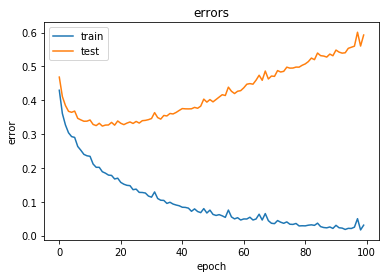

In [8]:
from utils import n_plot_graphs

n_plot_graphs(train_log, test_log, 'loss')

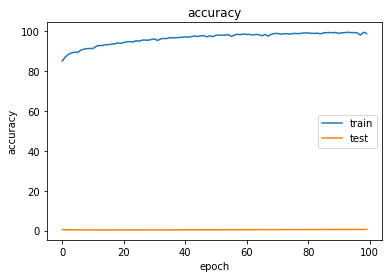

In [9]:
n_plot_graphs(train_log, test_log, 'accuracy')

In [27]:
test_log

{'default': [(0.3174367561817169, 91.15),
  (0.2408550163269043, 92.94),
  (0.19958798387050627, 94.15),
  (0.17202180874347686, 94.67),
  (0.15257697781324386, 95.42),
  (0.13403327289819716, 95.93),
  (0.12190695995092392, 96.35),
  (0.11166962240338325, 96.68),
  (0.1068451723575592, 96.72),
  (0.10148451241254806, 96.87),
  (0.09294669792503119, 97.13),
  (0.09206985440552234, 97.21),
  (0.08847811326533556, 97.34),
  (0.0866486031383276, 97.28),
  (0.08762764247506857, 97.35),
  (0.0841078143209219, 97.45),
  (0.0851175547786057, 97.44),
  (0.08364937973469495, 97.45),
  (0.08336126733217389, 97.6),
  (0.08229483855813742, 97.67),
  (0.08305189070999622, 97.61),
  (0.08675617944933474, 97.49),
  (0.08619866179004311, 97.66),
  (0.08653611945472657, 97.66),
  (0.08704996525347233, 97.71),
  (0.09011154256556184, 97.65),
  (0.08908834441173821, 97.68),
  (0.09195641261581332, 97.67),
  (0.09835801188591868, 97.58),
  (0.09565127716157586, 97.65),
  (0.10143983636088669, 97.5),
  (0.